In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plot_size = (9, 9)  # Ensure all plots have the same dimensions
plotly_conv = 100

# Preprocessing the Data
The data gets rescaled by market capitalization to rescale the features according to company size. We are still discarding the tob and bottom percentile based on each feature, i guess many of the discarded companies are just too big to be compared to the others or they have wrong data in the balance sheet. 

Since the dataset contains datapoints for multiples years, it has been chosen (for simplicity) to take the last year value of the given feature

Attempted solutions:
- Using Powertransform that should have worked, since this is a dataset with outliers, but it didn't fit the case since all other points where smashed to 0

In [5]:
import jsonlines as jl
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer

features = ["ebitda", "sh_funds", "net_fin", "tang_assets"]
data_list = []

def parse(val):
    v = val[0] if isinstance(val, list) else val
    try:
        return float(v)
    except (ValueError, TypeError):
        return np.nan


# Read the jsonlines file and build the data list.
with jl.open("final.jsonl") as reader:
    for company in reader:
        if all(f in company for f in features) and "market_cap" in company:
            row = {}
            row["name"] = company["name"]
            mc = parse(company["market_cap"])
            for f in features:
                row[f] = parse(company[f]) / mc
            data_list.append(row)

df = pd.DataFrame(data_list)
df = df.dropna()

df.to_csv("data.csv", index=False)
df_unscaled = df.copy()
df_unscaled.to_csv("data_unscaled.csv", index=False)

df[features] =RobustScaler().fit_transform(df[features])
# Apply Quantile Transformer to make distribution normal
# df[features] = QuantileTransformer(
#     output_distribution="normal", random_state=42
# ).fit_transform(df[features])

df.to_csv("cleaned_data.csv", index=False)

print(df)

                                       name    ebitda  sh_funds   net_fin  \
0                                     Aedes -1.682397  0.651478 -1.504159   
1                                 Alfonsino -2.365137 -0.245671 -0.457040   
2                            Alfio Bardolla -0.436477 -0.468494 -0.364103   
3                                   Alerion  0.102016 -0.357347 -0.605053   
4    Aeroporto Guglielmo Marconi Di Bologna -0.044325  0.100357 -0.323038   
..                                      ...       ...       ...       ...   
345                              Yolo Group -1.166799  0.377002 -0.501964   
346               Xenia Hotellerie Solution  1.731685 -0.005312  1.392285   
347                                    Wiit -0.338758 -0.724962 -0.260657   
348                                 Webuild  0.590806  0.194200 -1.233512   
349                               Websolute -0.593268 -0.472338  0.321459   

     tang_assets  
0      -0.152297  
1      -0.333131  
2      -0.044423  

# Exploratory Data Analysis
See what the data tells us before doing any Machine Learning on it

## Histograms

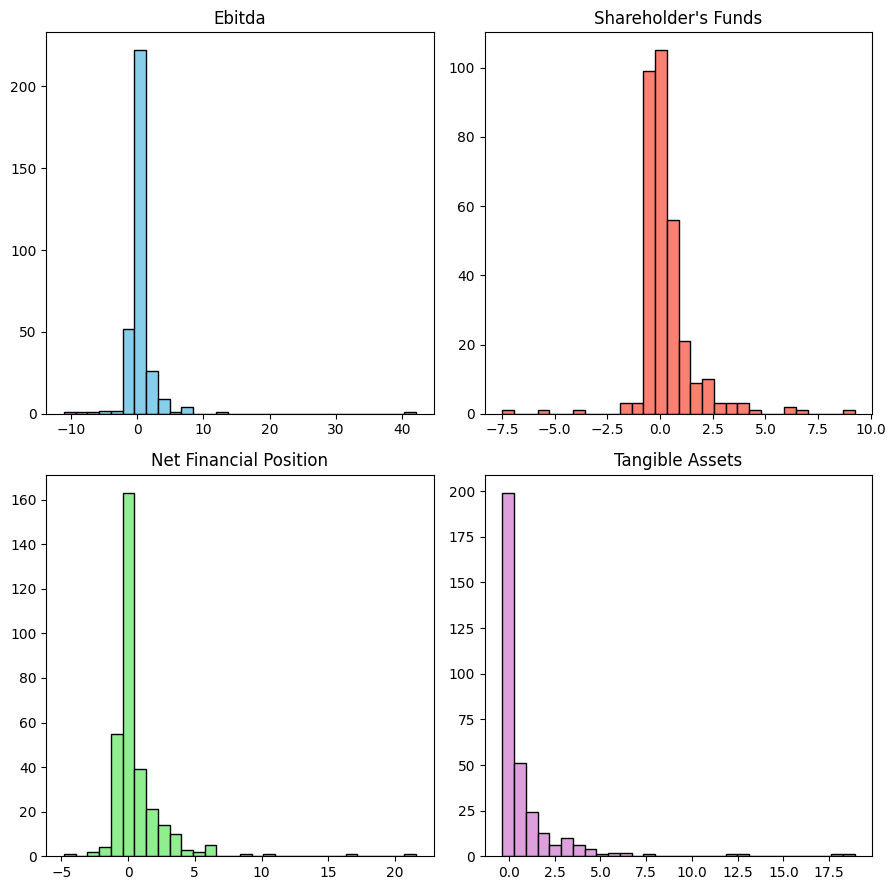

In [6]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=plot_size)

axs[0, 0].hist(df["ebitda"], bins=30, color="skyblue", edgecolor="black")
axs[0, 0].set_title("Ebitda")

axs[0, 1].hist(df["sh_funds"], bins=30, color="salmon", edgecolor="black")
axs[0, 1].set_title("Shareholder's Funds")

axs[1, 0].hist(df["net_fin"], bins=30, color="lightgreen", edgecolor="black")
axs[1, 0].set_title("Net Financial Position")

axs[1, 1].hist(df["tang_assets"], bins=30, color="plum", edgecolor="black")
axs[1, 1].set_title("Tangible Assets")

plt.tight_layout()

## Basics Statistics

Descriptive Statistics:
           ebitda    sh_funds     net_fin  tang_assets
count  323.000000  323.000000  323.000000   323.000000
mean     0.231143    0.876750    0.485636     0.587354
std      0.658313    1.078144    1.184804     1.154888
min     -2.344531   -5.351613   -2.468893     0.000049
25%      0.068148    0.342975   -0.009952     0.057048
50%      0.142989    0.650297    0.165088     0.191805
75%      0.292187    1.146190    0.538226     0.597737
max      9.582337    8.066646   11.990211    10.409046


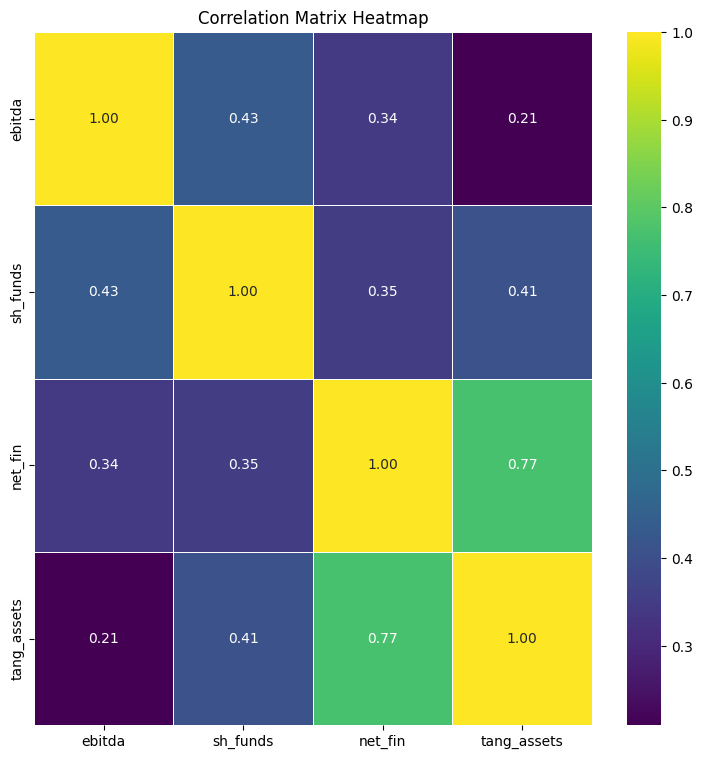

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("data.csv")  # Adjust path if needed

# Descriptive statistics
descriptive_stats = df.describe()
print("Descriptive Statistics:")
print(descriptive_stats)

# Display correlation matrix
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=plot_size)
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Financial Health Indicators
Indicators are:
$$
\begin{aligned}
    \text{Debt To Equity} &\quad= \frac{\text{Net Financial Position}}{\text{Shareholders Funds}} \\ \\
    \text{Ebitda Margin} &\quad= \frac{\text{Ebitda}}{\text{Tangible Assets}} \\  \\
    \text{ROE} &\quad= \frac{\text{Ebitda}}{\text{Shareholder Funds}} 
\end{aligned}
$$


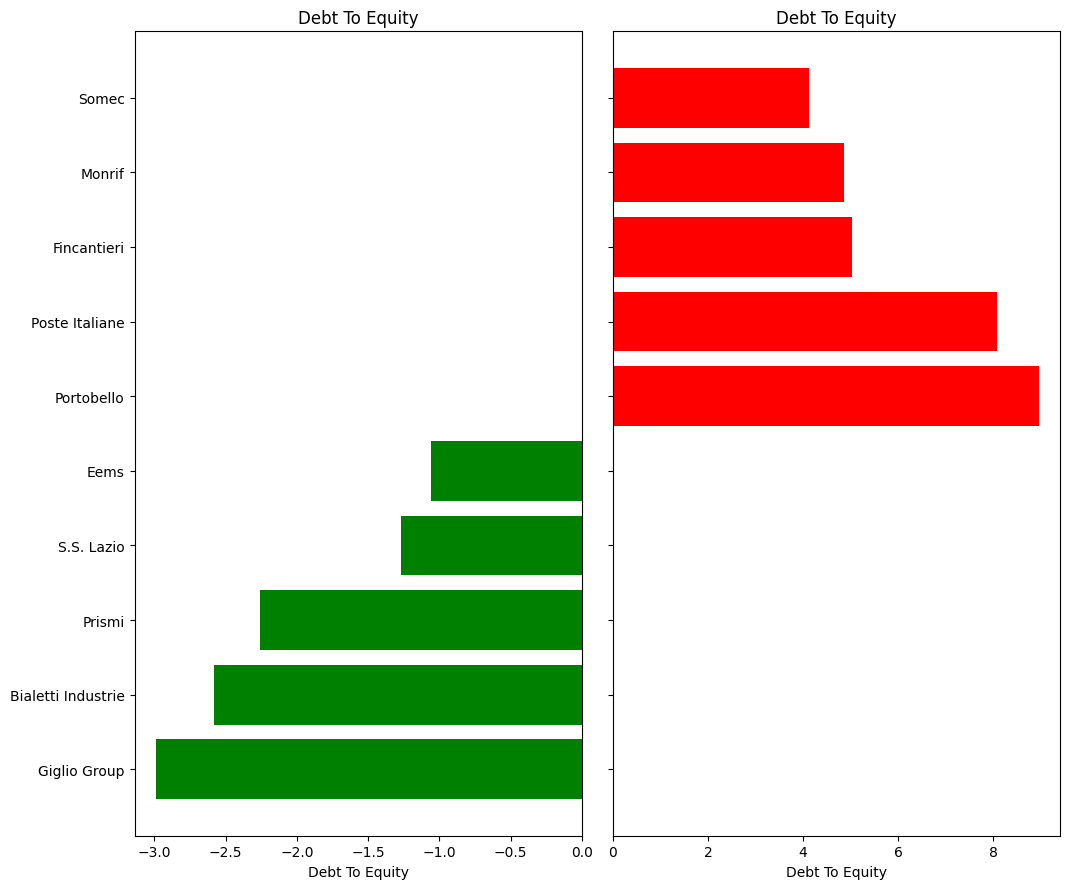

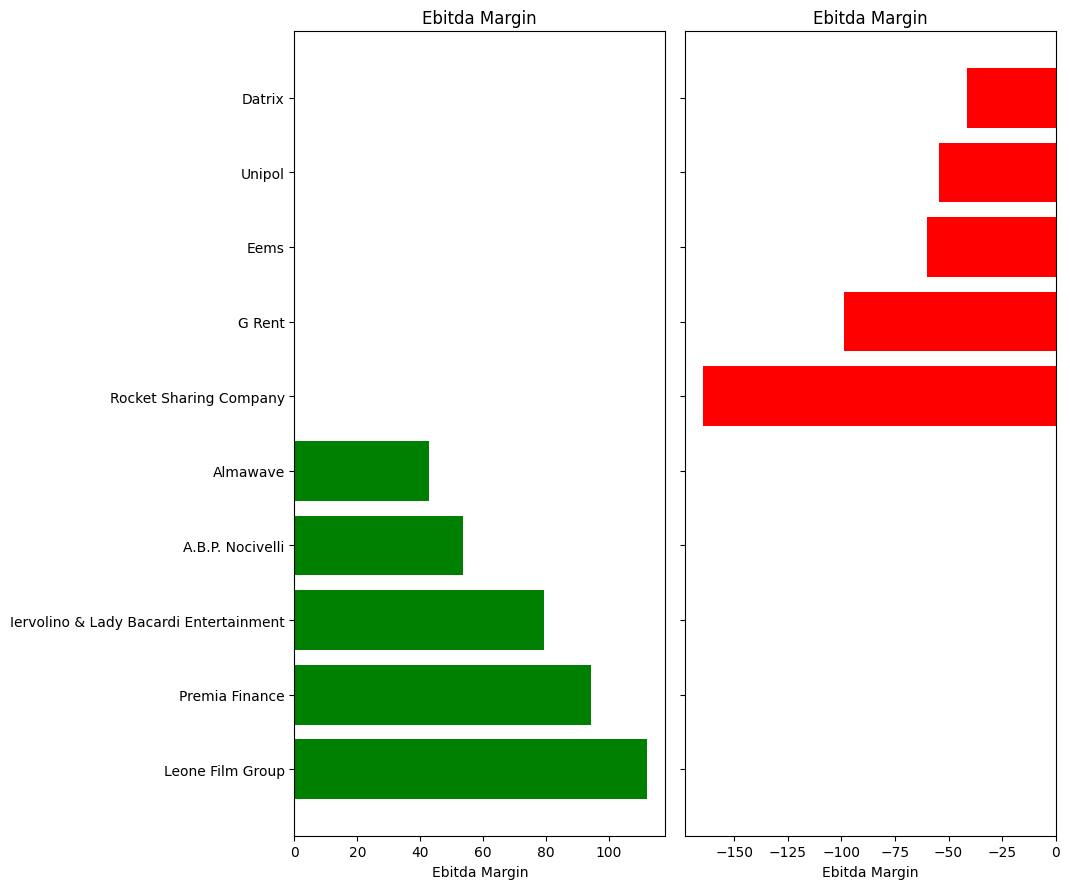

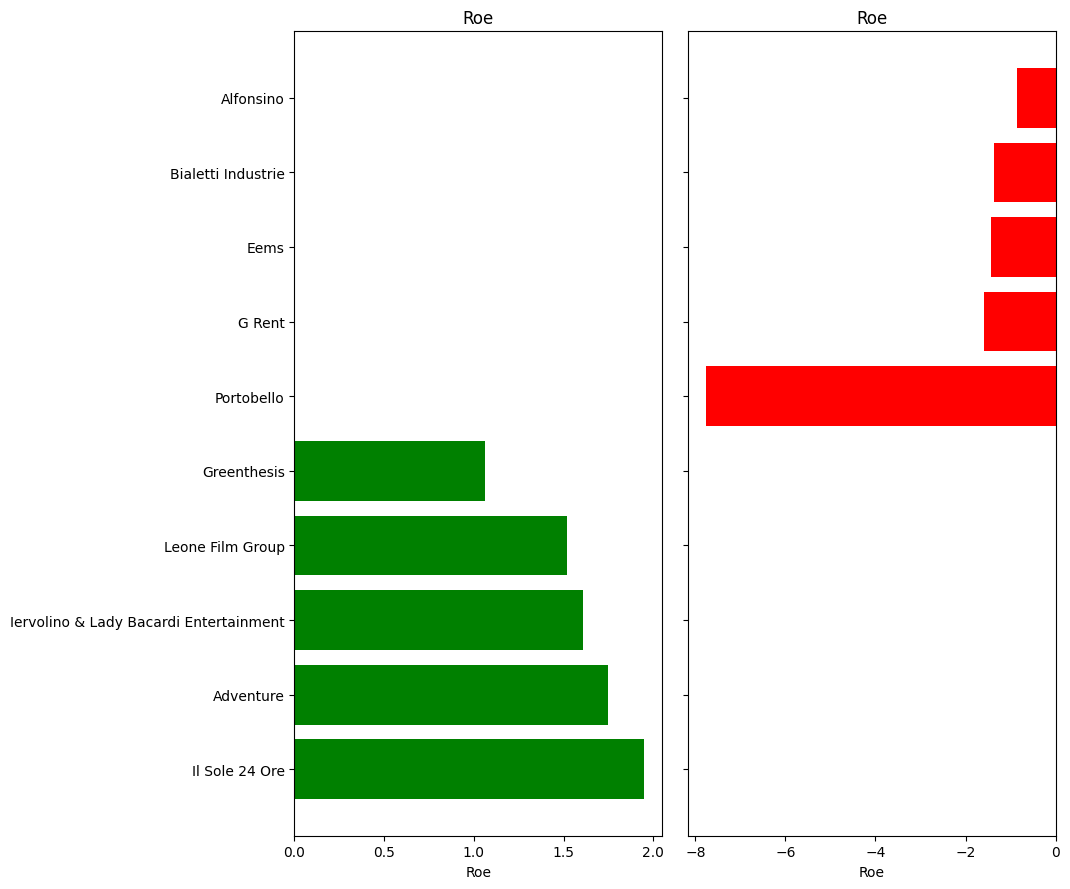

In [8]:
# Load dataset (Ensure this is the unscaled dataset)
file_path = "data.csv"  # Update this path if needed
df_unscaled = pd.read_csv(file_path)

# Calculate financial metrics
df_unscaled["debt_to_equity"] = df_unscaled["net_fin"] / df_unscaled["sh_funds"]
df_unscaled["ebitda_margin"] = df_unscaled["ebitda"] / df_unscaled["tang_assets"]
df_unscaled["roe"] = df_unscaled["ebitda"] / df_unscaled["sh_funds"]

# Define sorting order for each metric
metric_sorting = {
    "debt_to_equity": False,  # Lower is better
    "ebitda_margin": True,  # Higher is better
    "roe": True,  # Higher is better
}


# Function to plot top and bottom 5 companies for a given metric without forced alignment
def plot_ranked_companies(df, metric, ascending=True):
    if ascending:
        top_5 = df.nlargest(5, metric)[["name", metric]].round(2)  # Higher is better
        bottom_5 = df.nsmallest(5, metric)[["name", metric]].round(2)  # Lower is worse
    else:
        top_5 = df.nsmallest(5, metric)[["name", metric]].round(2)  # Lower is better
        bottom_5 = df.nlargest(5, metric)[["name", metric]].round(2)  # Higher is worse

    fig, axes = plt.subplots(1, 2, figsize=(plot_size[0]*1.2, plot_size[1]), sharey=True)

    # Top 5 Companies Bar Plot
    axes[0].barh(top_5["name"], top_5[metric], color="green")
    axes[0].set_title(f"{metric.replace('_', ' ').title()}")
    axes[0].invert_yaxis()  # Keep highest value at the top
    axes[0].set_xlabel(metric.replace("_", " ").title())

    # Bottom 5 Companies Bar Plot
    axes[1].barh(bottom_5["name"], bottom_5[metric], color="red")
    axes[1].set_title(f"{metric.replace('_', ' ').title()}")
    axes[1].invert_yaxis()  # Keep highest value at the top
    axes[1].set_xlabel(metric.replace("_", " ").title())

    # Adjust layout to ensure bars are fully visible
    plt.tight_layout()
    plt.show()


# Generate plots for each financial metric
for metric, ascending in metric_sorting.items():
    plot_ranked_companies(df_unscaled, metric, ascending)

# PCA

In [9]:
from sklearn.decomposition import PCA
import plotly.express as px

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

pca = PCA(n_components=3)
X_pca = pca.fit_transform(df[features])
df["PCA1"], df["PCA2"], df["PCA3"] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 3D PCA Visualization with hover labels, smaller dots, and larger plot
fig = px.scatter_3d(
    df,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    hover_name="name",
    title="3D PCA Scatter Plot",
    size_max=5,
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=plot_size[0]*plotly_conv, height=plot_size[1]*plotly_conv)
fig.show()

Explained Variance Ratio: [0.57100437 0.23448465 0.14389848]


# Pairplots

In [10]:
import plotly.express as px

# Select only numerical columns and include company name for hover info
selected_columns = ["name", "ebitda", "sh_funds", "net_fin", "tang_assets"]
df_selected = df[selected_columns]

# Create the scatter matrix with square aspect ratio
fig = px.scatter_matrix(
    df_selected,
    dimensions=["ebitda", "sh_funds", "net_fin", "tang_assets"],  # Numerical features
    hover_name="name",  # Show company name on hover
    title="Interactive Pairplot with Company Names",
)

# Set square layout by adjusting figure size
fig.update_layout(
    autosize=False,
    width=plot_size[0]*plotly_conv,  # Set width
    height=plot_size[1]*plotly_conv,  # Set height (same as width to enforce square shape)
    margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins
)

# Show the plot
fig.show()

# Analysis without Outliers

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the dataset
file_path = "data.csv"  # Update this path if needed
df = pd.read_csv(file_path)


# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound
        cleaned_df = cleaned_df[
            (cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)
        ]
    return cleaned_df


# Select numerical columns for outlier removal
numerical_columns = ["ebitda", "sh_funds", "net_fin", "tang_assets"]
df_cleaned = remove_outliers(df, numerical_columns)

# Display summary statistics of cleaned data
print("Summary Statistics (Without Outliers):")
print(df_cleaned.describe())




Summary Statistics (Without Outliers):
           ebitda    sh_funds     net_fin  tang_assets
count  250.000000  250.000000  250.000000   250.000000
mean     0.143753    0.645841    0.149092     0.259227
std      0.131581    0.418983    0.320606     0.303292
min     -0.234077   -0.231850   -0.775490     0.000049
25%      0.065561    0.309709   -0.032207     0.039586
50%      0.130373    0.594213    0.094220     0.128146
75%      0.218764    0.878990    0.273592     0.417970
max      0.524842    2.152291    1.224086     1.371798


## Correlation Heatmap

Summary Statistics (Without Outliers):
           ebitda    sh_funds     net_fin  tang_assets
count  250.000000  250.000000  250.000000   250.000000
mean     0.143753    0.645841    0.149092     0.259227
std      0.131581    0.418983    0.320606     0.303292
min     -0.234077   -0.231850   -0.775490     0.000049
25%      0.065561    0.309709   -0.032207     0.039586
50%      0.130373    0.594213    0.094220     0.128146
75%      0.218764    0.878990    0.273592     0.417970
max      0.524842    2.152291    1.224086     1.371798


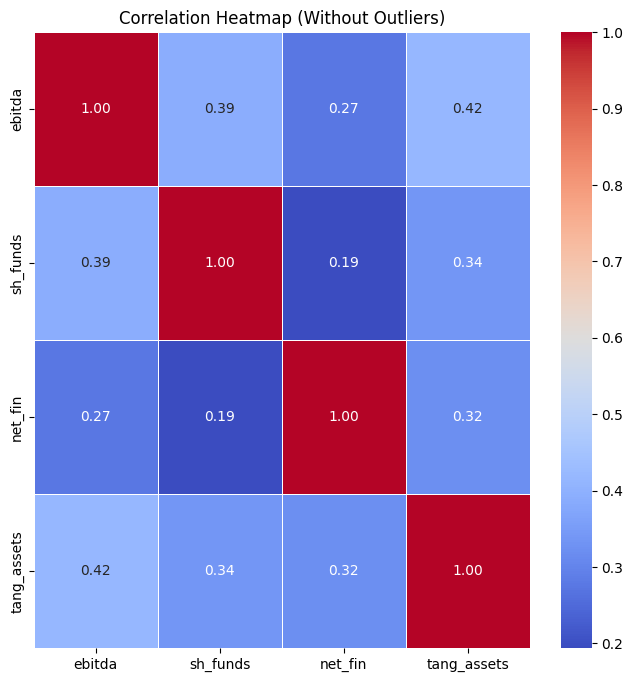

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the dataset
file_path = "data.csv"  # Update this path if needed
df = pd.read_csv(file_path)


# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound
        cleaned_df = cleaned_df[
            (cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)
        ]
    return cleaned_df


# Select numerical columns for outlier removal
numerical_columns = ["ebitda", "sh_funds", "net_fin", "tang_assets"]
df_cleaned = remove_outliers(df, numerical_columns)

# Display summary statistics of cleaned data
print("Summary Statistics (Without Outliers):")
print(df_cleaned.describe())

# Set consistent figure size
plot_size = (8, 8)  # Ensure all plots have the same dimensions

# 1. Correlation Heatmap
plt.figure(figsize=plot_size)
sns.heatmap(
    df_cleaned.corr(numeric_only=True),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Heatmap (Without Outliers)")
plt.show()


## Histograms

<Figure size 800x800 with 0 Axes>

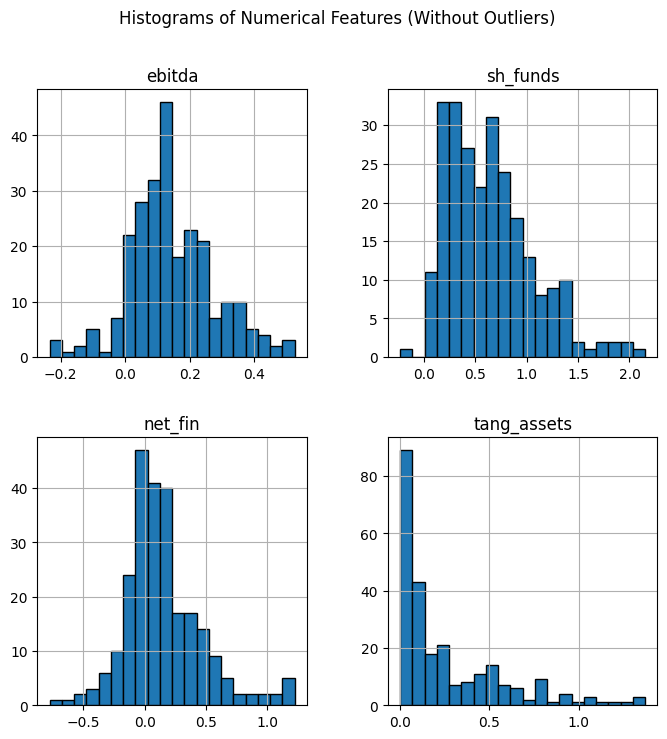

In [13]:
# 2. Histograms of all numerical columns
plt.figure(figsize=plot_size)
df_cleaned.hist(figsize=plot_size, bins=20, edgecolor="black")
plt.suptitle("Histograms of Numerical Features (Without Outliers)")
plt.show()


## Boxplots

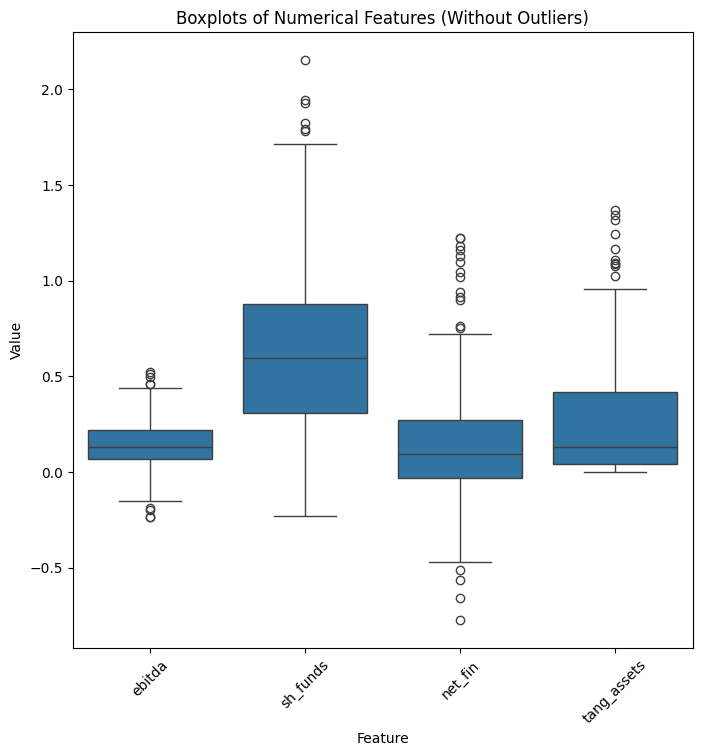

In [14]:
# 3. Boxplots for numerical features
plt.figure(figsize=plot_size)
df_melted = df_cleaned.melt(id_vars=["name"], var_name="Feature", value_name="Value")
sns.boxplot(x="Feature", y="Value", data=df_melted)
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features (Without Outliers)")
plt.show()


## PCA

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Define feature columns for PCA (excluding non-numeric columns)
features = [
    "ebitda",
    "sh_funds",
    "net_fin",
    "tang_assets",
]  # Update with actual numerical columns

# Separate numeric data and non-numeric columns
df_numeric = df_cleaned[features]  # Select only numerical features
df_non_numeric = df_cleaned[["name"]]  # Keep non-numeric columns separately

# Standardize the numerical data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_scaled)

# Create a new DataFrame with PCA results and reattach the 'name' column
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
df_pca = pd.concat([df_non_numeric.reset_index(drop=True), df_pca], axis=1)

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 3D PCA Visualization with hover labels
fig = px.scatter_3d(
    df_pca, x="PCA1", y="PCA2", z="PCA3", hover_name="name", title="3D PCA Scatter Plot"
)

# Adjust marker size and figure size
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=800)  # Equivalent to figsize=(8,8)

# Show the plot
fig.show()

Explained Variance Ratio: [0.49464729 0.20608976 0.15694371]


## Pariplots

In [16]:
# 4. Interactive Pairplot with Company Names (All Plots Square)
selected_columns = ["name", "ebitda", "sh_funds", "net_fin", "tang_assets"]
df_selected_cleaned = df_cleaned[selected_columns]

for feature in selected_columns:
    if feature == "name":
        continue
    fig = px.scatter_matrix(
        df_selected_cleaned,
        dimensions=["ebitda", "sh_funds", "net_fin", "tang_assets"],  # Numerical features
        hover_name="name",  # Show company name on hover
        title="Interactive Pairplot (Without Outliers)",
        color=feature,  # Optional: Color based on sh_funds
    )

    # Ensure square layout for interactive plot
    fig.update_layout(
        autosize=False,
        width=plot_size[0] * plotly_conv,  # Same width as static plots
        height=plot_size[1] * plotly_conv,  # Same height as static plots
        margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins
    )

    # Show the interactive plot
    fig.show()